## Preparing the dataset 

The full MNIST handwritten digits dataset can easily be downloaded and loaded in memory with scikit-learn: 

In [1]:
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

Then, we print basic information about the dataset: 

In [2]:
import numpy as np
print(images.shape)
print(np.max(images))
print(np.unique(labels))

(70000, 784)
255.0
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


We see that we have 70 000 digit examples. Each image has 28x28=784 pixels, flattened into a 1D array. There is a single color channel for each pixel, so these are grayscale images. The maximum grayscale level is 255. 

Neural networks prefer to deal with numbers close to unity, so we need to normalize our grayscale levels:

In [3]:
images = images / 255. 
np.max(images)

1.0


The label provides the ground truth for each image, and is stored as a string. 

Neural networks deal with numbers, not strings. So let's convert the labels to integers: 

In [4]:
labels = labels.astype(int)
labels

array([5, 0, 4, ..., 4, 5, 6])

Given an image, the network will produce 10 values from its output neurons. They are the estimated probabilities for the image to belong to each category. 

During the training, these 10 values will need to be compared to the target (currently a single label between 0 and 9), and the network parameters will be adapted so that later on, the network predictions are brought closer to the target. 

But how can we compare a vector of 10 values with a single label value? 

The solution is to translate each label to a vector of length 10 with a technique called *one-hot encoding*: 

* label `0` is translated to `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* label `1` is translated to `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* label `9` is translated to `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

After doing that, the values from the output neurons, which are probabilities ranging from 0 to 1, can be compared directly to the values in the target vector. In this way, for a given number, say 0, the neural network will be trained to output a high probability from the first output neuron, and a low probability from the following neurons.  

One-hot encoding can be performed easily with the utilities provided by Keras: 

In [5]:
from keras.utils import np_utils
targets = np_utils.to_categorical(labels,10)
np.set_printoptions(edgeitems=5)
print(labels)
print(targets)
np.set_printoptions(edgeitems=3)


Using TensorFlow backend.


[5 0 4 1 9 ... 2 3 4 5 6]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


Finally, we split our data into a training sample and a testing sample:

In [6]:
test_size=10000
x_test = images[:test_size]
y_test = targets[:test_size]
x_train = images[test_size:]
y_train = targets[test_size:]

The first 10 000 images and labels are going to be used later to test the performance of our network, and the remaining images will be used for training. 

Why 10 000 images and not 1000? Just to have enough statistics for a precise estimation of the network performance, we will come back to that. 

## Simple dense neural network with Keras

As a first step, just to get familiar with the Keras interface, we will train a simple dense neural network to identify our digits. 

In machine learning, it's always good to start with a simple model, and to gradually make it more complex only if necessary. 

So we'll start with a super simple network with: 

* layer 1: input layer with 784 nodes 
* layer 2: dense layer with 3 neurons, with ReLU activation (yes, only three!)
* layer 3: dense layer with 10 neurons, with softmax activation. 

The neurons of layers 2 and 3 are fully connected to the neurons of the previous layer. So there is a high density of connections before these layers, and that is why they are called dense layers. A neural network with dense layers is called a dense network.

Keras offers two ways to define neural networks: the sequential API and the functional API. Generally speaking, the sequential API allows for more compact and readable code, and the functional API for more flexible networks. 

### Sequential API

In [74]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Dense(3, input_shape=(images.shape[1],), activation='relu'), 
    layers.Dense(10, activation='softmax'),     
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 2355      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


We see that the first layer has 2355 parameters. Why? 

Remember that we have 784 input values, and 3 neurons on this layer. The weighted input for neuron $j$ is: 

$$z_j = \sum_{i=1}^{784} w_{ij} x_i + b_j$$

where $w_{ij}$ is the weight of the link carrying value $x_i$ to neuron $j$, and $b_j$ is the bias of neuron $j$. So we get 785 parameters for each of the 3 neurons, and 3x785=2355 parameters in total.

---

**Exercise:**

* In the same way, compute the number of parameters of the final layer. 

---

As you can see, this small neural network has 2395 parameters that will be optimized during the training. This already offers quite a bit of flexibility. 

### Functional API

With the functional API, the same network would be defined in this way: 

In [8]:
inputs = layers.Input(shape=(images.shape[1],))
out_1 = layers.Dense(3, activation='relu')(inputs)
predictions = layers.Dense(10, activation='softmax')(out_1)
model = models.Model(inputs, predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2355      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


In this case, `inputs`, `out_1`, and `predictions` are tensors. Or rather, since we are only defining the structure of the network, "symbolic" tensors. 

When the network is evaluated for a given image, actual tensors will flow through the network. 

Therefore, a layer can be seen as a function: it takes an input tensor and provides an output tensor. This is what is represented by the functional API.

### Training

Now that our neural network is defined, we need to compile it so that it can be trained and used. 

We specify that we want to use [Adam](https://arxiv.org/abs/1412.6980) as optimization method. The default learning rate for [Adam in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is 0.001. Here, I boost it to 0.01 to learn faster, as I have checked that the network is still able to learn with this rather large value. 

We also request to compute the accuracy of the model during training and testing. 

In [9]:
# define how the neural network will learn, 
# and compile the model. 
# models must be compiled before 
# they can be trained and used. 
# the loss, optimizer, and metrics arguments 
# will be covered in a future post. 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])


After compilation, we can train the network:

In [10]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=100, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.9748 - accuracy: 0.6719 - val_loss: 0.7237 - val_accuracy: 0.7751
Epoch 2/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.7086 - accuracy: 0.7795 - val_loss: 0.6734 - val_accuracy: 0.7940
Epoch 3/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.6796 - accuracy: 0.7911 - val_loss: 0.6717 - val_accuracy: 0.7993
Epoch 4/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.6645 - accuracy: 0.7969 - val_loss: 0.6772 - val_accuracy: 0.8033
Epoch 5/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.6505 - accuracy: 0.8012 - val_loss: 0.6705 - val_accuracy: 0.7998


We see that the network learns fast, and actually, the performance is already quite good, even with only 3 neurons on the hidden layer! 

---

**Exercise**

Actually, with such a low number of tunable parameters, the optimization can easily get stuck in local minima, and this depends on the random initialization of the network parameters before training. 

* Re-run the training several times, and see how the maximum accuracy varies. 

**Note that you need to re-create the model and re-compile it if you want to redo the training. Otherwise the network will start from its state at the end of the previous training.**

---

### Evaluation and performance metrics

Now that our network is trained, we can evaluate it for all images in the test sample:

In [11]:
predictions = model.predict(x_test)
predictions.shape

(10000, 10)

And we can write a small function to display the results of the evaluation for a set of images:

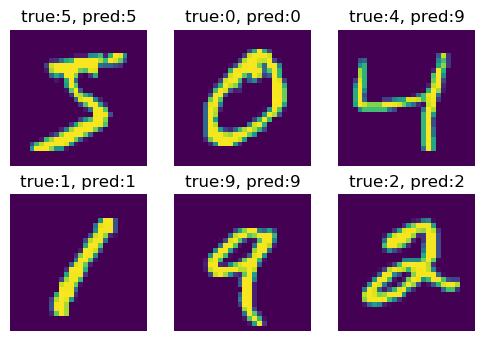

In [12]:
import matplotlib.pyplot as plt

def plot_images(indices, predictions): 
    if len(indices)>6:
        print('please provide at most 6 indices')
        return
    fig = plt.figure(dpi=100)
    for i, index in enumerate(indices):
        fig.add_subplot(2, 3, i+1)
        # our input images are flattened. 
        # restoring the pixel structure
        # before display.
        img = x_test[index].reshape(28,28)
        plt.imshow(img)
        # looking for slot with highest probability
        # in the one-hot encoded array:
        true_cat = np.argmax(y_test[index])
        pred_cat = np.argmax(predictions[index])
        plt.title('true:{}, pred:{}'.format(true_cat, pred_cat))
        plt.axis('off')

plot_images(np.arange(6), predictions)

---

**Exercise:**

* look at more images (just add an integer to `np.arange(6)` to look at another range of indices).

---

You might have noticed that the fit method of the Keras model returns a history object, and that we kept track of it. This object contains a `history` dictionary: 

In [18]:
history.history

{'loss': [0.9748266504208247,
  0.7086364056666692,
  0.6795609102149804,
  0.6645185395578543,
  0.6505232085287571],
 'accuracy': [0.67188334, 0.7794667, 0.79108334, 0.79691666, 0.80115],
 'val_loss': [0.7236541497707367,
  0.6734163522720337,
  0.6717397066950798,
  0.6772154721617699,
  0.6705315461754799],
 'val_accuracy': [0.7751, 0.794, 0.7993, 0.8033, 0.7998]}

We see that this dictionary contains loss and the accuracy as a function of the epoch, for both the training and validation (test) samples. To plot them, do: 

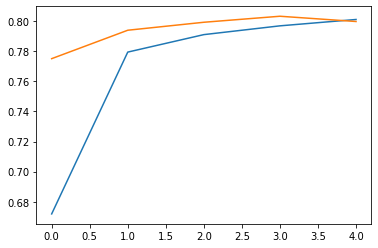

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

And we can write a function to plot the history, as it will need it several times later on: 

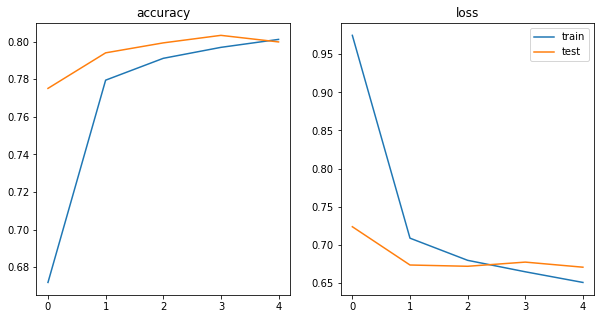

In [20]:
def plot_history(history, miny=None):
    hd = history.history
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1, 2, 1)
    plt.plot(hd['accuracy'])
    plt.plot(hd['val_accuracy'])
    if miny: 
        plt.ylim(miny, 1.0)
    plt.title('accuracy')
    fig.add_subplot(1, 2, 2)
    plt.plot(hd['loss'], label='train')
    plt.plot(hd['val_loss'], label='test')
    plt.title('loss')
    plt.legend()
    
plot_history(history)

We'll see how to tune the network for better performance later on. But for now, let's have a more detailed look at our trained model. 

### Internal representation and embedding

Here is again a summary of our model: 

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2355      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


Let's take a moment to really understand what happens when an image goes through the network. 

The image has 784 pixels, so the image is defined by 784 variables, which are the gray levels in the pixels. In other words, each image corresponds to a point in a space with 784 dimensions. 

The first hidden layer, the one with three neurons, has three output values. 

So what this layer is doing is to project the image from the original 784D space to 3D space. When you think about it, that's not an obvious task. The 3D coordinates of the image constitute an intermediate **representation**. 

Finally, the 3D space is partitioned with 10 planes in an attempt to separate the 10 digit categories. 

When we train the network, it learns how to do the 784D to 3D projection in such a way as to make the linear separation possible in the last layer of the network. 

Now why did I choose to put only three neurons in the hidden layer? because it's always good to start simple in machine learning as I've already said, and also because we can now visualize the intermediate 3D representation. With more dimensions, it would have been more difficult to display the representation, but not impossible. We'll come back to that.  

Let's display the 3D representation. For this, we need to create a function which takes a bunch of images and returns the output of the hidden layer: 

In [22]:
from tensorflow.keras import backend as K
# create the function:
hidden_repr = K.function([model.layers[0].input], 
                         [model.layers[1].output])
# compute the 3D representation for all images: 
embedding = hidden_repr([images])[0]
embedding.shape

(70000, 3)

We have 70 000 points. Trying to display them would kill your browser, so we are going to select only 1000 points: 

In [44]:
nsmall = 2000
small = embedding[:nsmall]
slabels = labels[:nsmall]

We enable the interactive mode of matplotlib so that we can interact with our plot later on.

In [45]:
%matplotlib inline

And finally we make the plot:

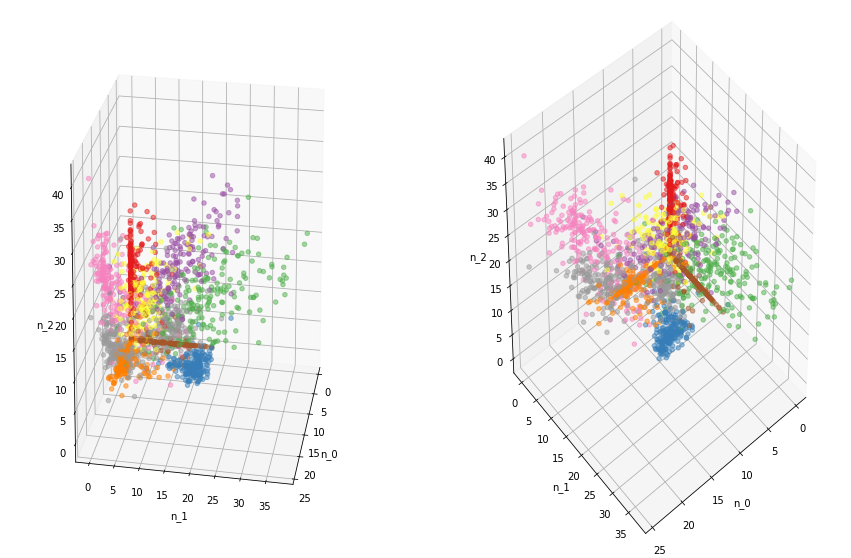

In [50]:
import mpl_toolkits.mplot3d.axes3d

def plot_3d():
    ax.scatter(small[:,0], small[:,1], small[:,2], c=slabels, cmap='Set1', alpha=0.5)
    ax.set_xlabel('n_0')
    ax.set_ylabel('n_1')
    ax.set_zlabel('n_2')

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121, projection='3d')
plot_3d()
ax.view_init(20,10)
ax = fig.add_subplot(122, projection='3d')
plot_3d()
ax.view_init(40,50)

It does seem that it's possible to separate the classes by running planes through the 3D space.

We see that some of the images end up with a vanishing value for some of the neurons. These images do not activate the corresponding ReLUs. 

If a single neuron does not fire, the point ends up on one of the three planes $n_1=0$, $n_2=0$ or $n_3=0$.
If two neurons did not fire, the point ends up on either the $n_1$, $n_2$, or $n_3$ axis.

All in all, this simple neural network seems to: 

* use the three planes and the three axes to distribute 6 of the 10 categories. 
* create combinations of the three activated ReLU outputs for the other four categories, in order to distribute them in 3D.  

### Hyperparameter tuning

--- 

**Exercise**

* Start to make the network more complex by adding neurons on the hidden layer, and then by adding a second dense hidden layer.
* In all cases check the performance and control overfitting with the plot_history function
* What maximum test accuracy can you reach? 

---

## First Convolutional Neural Network

In this section, you will build your first convolutional neural network. We'll start very simple just to check what kind of basic performance we can get with such a network, with respect to a dense network. 

Currently, the grayscale levels of the pixels of a given image are stored in a flat 1D array: 

In [51]:
x_train[0].shape

(784,)

Convolutional layers have a 2D structure, so we first need to reshape our images to their original 28x28 shape: 

In [55]:
x_train_2d = x_train.reshape(-1, 28, 28,1)
x_test_2d = x_test.reshape(-1, 28, 28,1)
x_train_2d.shape

(60000, 28, 28, 1)

Why (28,28,1) and not (28,28)? This could have worked as well, but Keras convolutional layers to take inputs with shape (px, py, ncolors), where px and py are the numbers of pixels, and ncolors is the number of color channels. 

Then, we create a convolutional network with only one convolutional layer:

In [70]:
model = models.Sequential([
    layers.Conv2D(10, 5, input_shape=(28,28,1), 
                  activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
flatten_3 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                57610     
Total params: 57,870
Trainable params: 57,870
Non-trainable params: 0
_________________________________________________________________


Here is a bit more information about the three layers in this network: 

* **Conv2D** : 2D convolutional layer.  
  * it will produce 10 features at each position of the kernel. 
  * the kernel size (or convolutional window) has a size of 3x3 pixels
* **Flatten** : Flattening layer. This layer turns the input tensor into a flat 1D array. We need this because the next layer is a dense layer, which can only work with a 1D array in input. This is just a reshaping operation, so there is no parameter nor activation function here. 
* **Dense** : Output layer. 

--- 

**Exercise**

Look at the model summary above, and: 

* prove that the number of parameters of the Conv2D layer is indeed equal to 100
* prove that the output of the Flatten layer is indeed equal to 6760
* prove that the number of parameters of the last Dense layer is indeed equal to 67610

---

Now, let's compile and fit our model: 


In [71]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])
history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=100, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 21s 343us/sample - loss: 0.1408 - accuracy: 0.9574 - val_loss: 0.0973 - val_accuracy: 0.9733
Epoch 2/5
60000/60000 [==============================] - 23s 378us/sample - loss: 0.0665 - accuracy: 0.9800 - val_loss: 0.0881 - val_accuracy: 0.9780
Epoch 3/5
60000/60000 [==============================] - 24s 400us/sample - loss: 0.0474 - accuracy: 0.9849 - val_loss: 0.0938 - val_accuracy: 0.9744
Epoch 4/5
60000/60000 [==============================] - 23s 381us/sample - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.0824 - val_accuracy: 0.9793
Epoch 5/5
60000/60000 [==============================] - 22s 371us/sample - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.1169 - val_accuracy: 0.9766


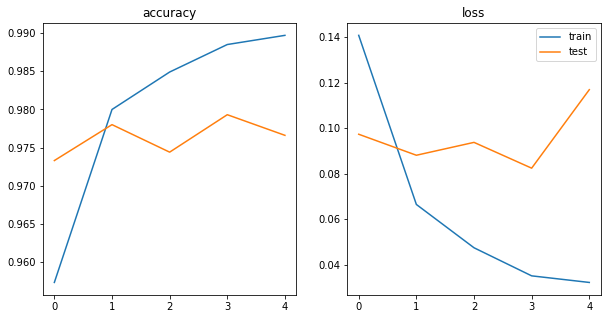

In [72]:
%matplotlib inline
plot_history(history)

We see that the convolutional neural network easily beats the dense neural network at this image classification task.

Here is the reason: 

The dense network starts with a dense layer featuring a huge number of parameters. Indeed, each neuron connects to all the pixels in the image, and you need many neurons to extract complex information. The large number of parameters makes the network very sensitive to overfitting. 

The convolutional network, on the other hand, starts by the convolutional layer, which has a very small number of parameters related to its kernel. But it's still able to learn complex information about the whole image because the Kernel is moved across the image. As a result, the convolutional network is much less sensitive to overfitting. 

That being said, our convolutional neural network is not yet complex enough, as we can guess from the fact that the *training* accuracy seems unable to reach 100%. You can train longer if you want to check that. Also, the test accuracy plateaus at a lower value than the test accuracy, which indicates that we already have a bit of overfitting. 

We'll see how to deal with overfitting later. But as a first step, one should first ensure that the network is complex enough to at least fit the training sample. 

## Stacked Convolutional Neural Network

## Dealing with overfitting

In [31]:
model = models.Sequential([
    layers.Conv2D(10, 3, input_shape=(28,28, 1), 
                  activation='relu'),
    layers.Flatten(),
    layers.Dropout(rate=0.5),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=100, epochs=20)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 10)        100       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6760)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6760)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                67610     
Total params: 67,710
Trainable params: 67,710
Non-trainable params: 0
_________________________________________________________________
Train on 68000 samples, validate on 2000 samples
Epoch 1/20
68000/68000 [==============================] - 3s 46us/sample - loss: 0.1883 - accuracy: 0.9430 - val_loss: 0.1210 - val_accuracy: 0.9655
Epoch 2/20
68000/68000 [==========================

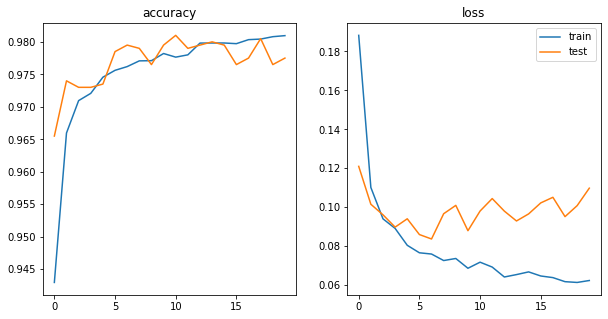

In [32]:
plot_history(history)

In [46]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28, 1), 
                  activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),    
    layers.MaxPooling2D(2), 
    layers.Flatten(),
    layers.Dropout(0.7),
    layers.Dense(100, activation='relu'), 
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=200, epochs=50)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 2048)            

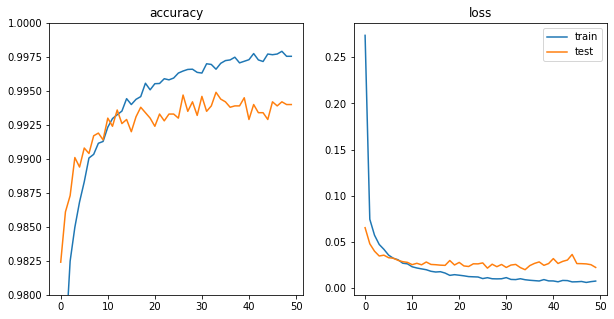

In [48]:
plot_history(history, miny=0.98)